In [134]:
import tensorflow as tf
from keras.datasets import cifar100
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, Activation, Lambda, Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow import keras
import numpy as np
from tensorflow.keras.utils import plot_model
import datetime, os
import time
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import VGG19

%load_ext tensorboard

In [34]:
from deakin.edu.au.data import Cifar100
import deakin.edu.au.models as models
import deakin.edu.au.metrics as metrics
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from graphviz import Digraph
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle
import numpy as np

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
#Load dataset
dataset = Cifar100()
num_classes = [dataset.num_classes_l0, dataset.num_classes_l1, dataset.num_classes_l2]
u = dataset.draw_taxonomy()
u.view()

# Set variables

batch = 128
epochs = 50
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
performance_callback = models.performance_callback(dataset.X_val, dataset.y_val, dataset.taxonomy)

checkpoint_filepath = '/tmp/checkpoint_new'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# Motivation plots

Model: "MLPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_60 (Flatten)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 2)                 1026      
Total params: 20,025,410
Trainable params: 20,025,410
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 13s 33ms/step - loss: 0.6584 - accuracy: 0.8104 - val_loss: 0.3368 - val_accuracy: 0.8602
Epoch 2/50
391/391 [==============================] - 12s 32ms/step - loss: 0.2974 - accuracy: 0.8

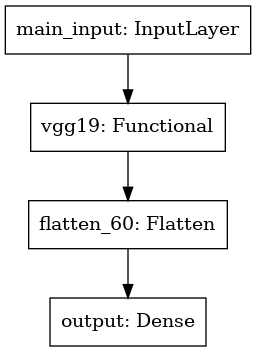

In [81]:
l0_model = models.get_Classifier_model(num_classes[0], dataset.image_size)
l0_model.summary()
#train model
history_l0_model = l0_model.fit(dataset.X_train, 
                    dataset.y_train[0],
                    validation_data = (dataset.X_val, dataset.y_val[0]), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback]
                    )
plot_model(l0_model)


Model: "MLPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_16 (Flatten)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 20)                10260     
Total params: 20,034,644
Trainable params: 20,034,644
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 13s 31ms/step - loss: 2.0376 - accuracy: 0.3708 - val_loss: 1.5766 - val_accuracy: 0.5014
Epoch 2/50
391/391 [==============================] - 12s 31ms/step - loss: 1.3304 - accuracy: 0.5

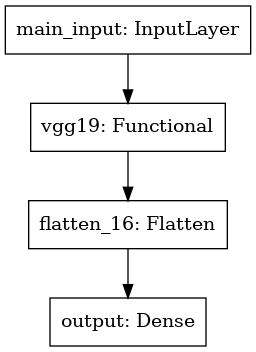

In [31]:
l1_model = models.get_Classifier_model(num_classes[1], dataset.image_size)
l1_model.summary()
#train model
history_l1_model = l1_model.fit(dataset.X_train, 
                    dataset.y_train[1],
                    validation_data = (dataset.X_val, dataset.y_val[1]), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback]
                    )
plot_model(l1_model)


Model: "MLPH_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 13s 33ms/step - loss: 4.4942 - accuracy: 0.0558 - val_loss: 3.8784 - val_accuracy: 0.1354
Epoch 2/50
391/391 [==============================] - 13s 33ms/step - loss: 3.2405 - accuracy: 0.2

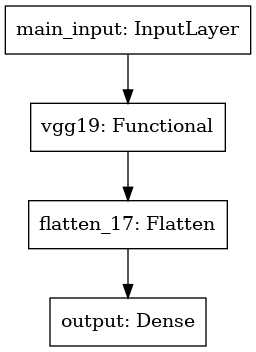

In [32]:
l2_model = models.get_Classifier_model(num_classes[2], dataset.image_size)
l2_model.summary()
#train model
history_l2_model = l2_model.fit(dataset.X_train, 
                    dataset.y_train[2],
                    validation_data = (dataset.X_val, dataset.y_val[2]), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[early_stopping_callback]
                    )
plot_model(l2_model)


In [35]:
l0_pred = np.argmax(l0_model.predict(dataset.X_test))
l1_pred = np.argmax(l1_model.predict(dataset.X_test))
l2_pred = np.argmax(l2_model.predict(dataset.X_test))
# baseline_model_pred = baseline_model.predict(dataset.X_test)
# baseline_model_pred = models.get_pred_indexes(baseline_model_pred)


In [40]:
metrics.get_accuracy(mnets_model_pred, dataset.y_test)

[0.915, 0.6474, 0.5024]

In [41]:
metrics.get_accuracy(baseline_model_pred, dataset.y_test)

[0.925, 0.6428, 0.5036]

# Training all models

Model: "mout_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_120 (Flatten)           (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
out_level_0 (Dense)             (None, 2)            1026        flatten_120[0][0]                
_________________________________________________________________________________________

391/391 [==============================] - 13s 34ms/step - loss: 1.1312 - out_level_0_loss: 0.1648 - out_level_1_loss: 1.1204 - out_level_2_loss: 2.1084 - out_level_0_accuracy: 0.9377 - out_level_1_accuracy: 0.6432 - out_level_2_accuracy: 0.4532 - val_loss: 1.2647 - val_out_level_0_loss: 0.2086 - val_out_level_1_loss: 1.2827 - val_out_level_2_loss: 2.3026 - val_out_level_0_accuracy: 0.9196 - val_out_level_1_accuracy: 0.6068 - val_out_level_2_accuracy: 0.4106
----------------------------------------------------------------------------------------------------
epoch=9, Exact Match = 0.3538, accuracy level_0 = 0.9196, accuracy level_1 = 0.6068, accuracy level_2 = 0.4106, Consistency = 0.6604
----------------------------------------------------------------------------------------------------

Epoch 10/50
391/391 [==============================] - 13s 34ms/step - loss: 1.0560 - out_level_0_loss: 0.1491 - out_level_1_loss: 1.0506 - out_level_2_loss: 1.9682 - out_level_0_accuracy: 0.9440 - out

391/391 [==============================] - 13s 33ms/step - loss: 0.4970 - out_level_0_loss: 0.0403 - out_level_1_loss: 0.4692 - out_level_2_loss: 0.9814 - out_level_0_accuracy: 0.9864 - out_level_1_accuracy: 0.8456 - out_level_2_accuracy: 0.7195 - val_loss: 1.2423 - val_out_level_0_loss: 0.2748 - val_out_level_1_loss: 1.3473 - val_out_level_2_loss: 2.1048 - val_out_level_0_accuracy: 0.9276 - val_out_level_1_accuracy: 0.6526 - val_out_level_2_accuracy: 0.5012
----------------------------------------------------------------------------------------------------
epoch=19, Exact Match = 0.4386, accuracy level_0 = 0.9276, accuracy level_1 = 0.6526, accuracy level_2 = 0.5012, Consistency = 0.7424
----------------------------------------------------------------------------------------------------

Epoch 20/50
391/391 [==============================] - 13s 34ms/step - loss: 0.4394 - out_level_0_loss: 0.0330 - out_level_1_loss: 0.4073 - out_level_2_loss: 0.8780 - out_level_0_accuracy: 0.9891 - ou

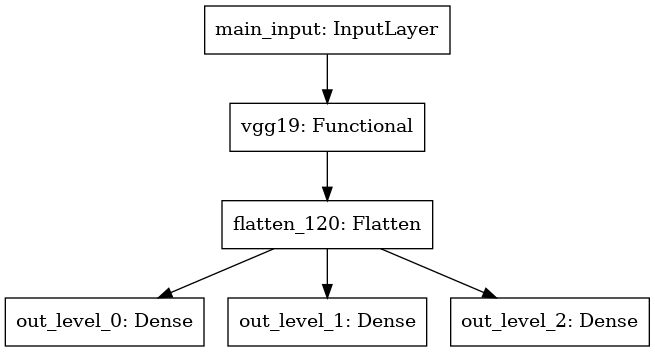

In [110]:
# Create the model
mout_model = models.get_mout_model(num_classes, dataset.image_size)
mout_model.summary()
#train model
history_mout_model = mout_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(mout_model)


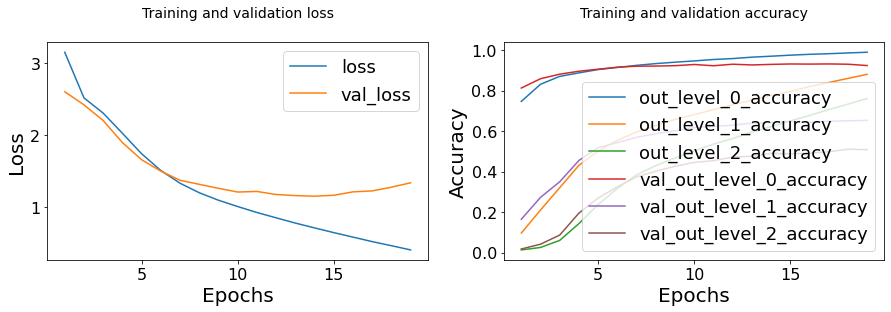

In [111]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1, 2, 1)
for l in history_MLPH_model.history:
    if l == 'loss' or l == 'val_loss':  
        loss = history_MLPH_model.history[l]
        plt.plot(range(1, len(loss) + 1), loss, label=l)
        
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
for k in history_MLPH_model.history:
    if 'accuracy' in k:  
        loss = history_MLPH_model.history[k]
        plt.plot(range(1, len(loss) + 1), loss, label=k)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Model: "Model_BCNN1_reversed_False"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
out_level_0 (Dense)          (None, 2)                 1026      
_________________________________________________________________
out_level_1 (Dense)          (None, 20)                60        
_________________________________________________________________
out_level_2 (Dense)          (None, 100)               2100      
Total params: 20,027,570
Trainable params: 20,027,570
Non-trainable params: 0
____________________________

391/391 [==============================] - 13s 33ms/step - loss: 2.5211 - out_level_0_loss: 0.0674 - out_level_1_loss: 2.8922 - out_level_2_loss: 4.6037 - out_level_0_accuracy: 0.9761 - out_level_1_accuracy: 0.0947 - out_level_2_accuracy: 0.0182 - val_loss: 2.5919 - val_out_level_0_loss: 0.2624 - val_out_level_1_loss: 2.9093 - val_out_level_2_loss: 4.6041 - val_out_level_0_accuracy: 0.9196 - val_out_level_1_accuracy: 0.0920 - val_out_level_2_accuracy: 0.0166
----------------------------------------------------------------------------------------------------
epoch=10, Exact Match = 0.0076, accuracy level_0 = 0.9196, accuracy level_1 = 0.0920, accuracy level_2 = 0.0166, Consistency = 0.3210
----------------------------------------------------------------------------------------------------

Epoch 11/50
391/391 [==============================] - 13s 34ms/step - loss: 2.5134 - out_level_0_loss: 0.0505 - out_level_1_loss: 2.8862 - out_level_2_loss: 4.6034 - out_level_0_accuracy: 0.9827 - ou

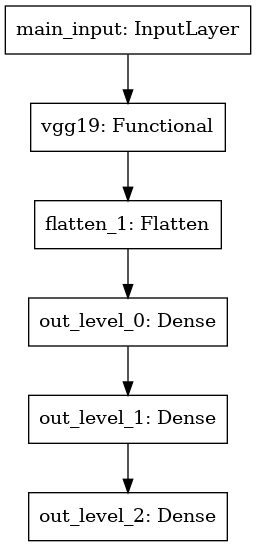

In [5]:
# Create the model
BCNN1_model = models.get_BCNN1(num_classes, dataset.image_size)
BCNN1_model.summary()
#train model
history_BCNN1_model = BCNN1_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_model)


Model: "Model_BCNN1_reversed_True"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
out_level_2 (Dense)          (None, 100)               51300     
_________________________________________________________________
out_level_1 (Dense)          (None, 20)                2020      
_________________________________________________________________
out_level_0 (Dense)          (None, 2)                 42        
Total params: 20,077,746
Trainable params: 20,077,746
Non-trainable params: 0
_____________________________

391/391 [==============================] - 13s 34ms/step - loss: 1.5713 - out_level_0_loss: 0.6795 - out_level_1_loss: 2.9595 - out_level_2_loss: 1.0749 - out_level_0_accuracy: 0.6500 - out_level_1_accuracy: 0.1383 - out_level_2_accuracy: 0.7014 - val_loss: 1.9099 - val_out_level_0_loss: 0.6789 - val_out_level_1_loss: 2.9629 - val_out_level_2_loss: 2.0877 - val_out_level_0_accuracy: 0.6480 - val_out_level_1_accuracy: 0.1238 - val_out_level_2_accuracy: 0.5020
----------------------------------------------------------------------------------------------------
epoch=10, Exact Match = 0.0526, accuracy level_0 = 0.6480, accuracy level_1 = 0.1238, accuracy level_2 = 0.5020, Consistency = 0.0998
----------------------------------------------------------------------------------------------------

Epoch 11/50
391/391 [==============================] - 13s 33ms/step - loss: 1.5237 - out_level_0_loss: 0.6777 - out_level_1_loss: 2.9543 - out_level_2_loss: 0.9390 - out_level_0_accuracy: 0.6500 - ou

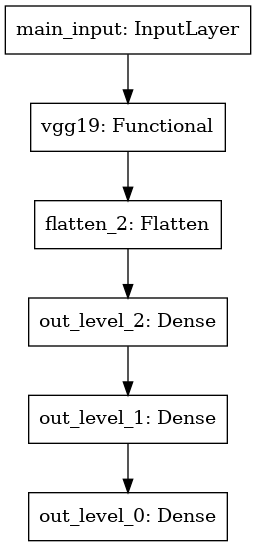

In [6]:
# Create the model
BCNN1_reversed_model = models.get_BCNN1(num_classes, dataset.image_size, reverse=True)
BCNN1_reversed_model.summary()
#train model
history_BCNN1_reversed_model = BCNN1_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(BCNN1_reversed_model)

Model: "Model_BCNN2_reversed_False"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 512)          0           vgg19[0][0]                      
__________________________________________________________________________________________________
logits_level_0 (Dense)          (None, 2)            1026        flatten_3[0][0]                  
_________________________________________________________________________

2021-07-19 19:22:44.791000: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/checkpoint_new/assets
Epoch 2/50
391/391 [==============================] - 13s 33ms/step - loss: 2.6274 - out_level_0_loss: 0.3956 - out_level_1_loss: 2.8502 - out_level_2_loss: 4.6362 - out_level_0_accuracy: 0.8398 - out_level_1_accuracy: 0.1317 - out_level_2_accuracy: 0.0083 - val_loss: 2.6158 - val_out_level_0_loss: 0.3698 - val_out_level_1_loss: 2.8332 - val_out_level_2_loss: 4.6444 - val_out_level_0_accuracy: 0.8454 - val_out_level_1_accuracy: 0.1320 - val_out_level_2_accuracy: 0.0076
----------------------------------------------------------------------------------------------------
epoch=2, Exact Match = 0.0000, accuracy level_0 = 0.8454, accuracy level_1 = 0.1320, accuracy level_2 = 0.0076, Consistency = 0.0000
----------------------------------------------------------------------------------------------------

INFO:tensorflow:Assets written to: /tmp/checkpoint_new/assets
Epoch 3/50
391/391 [==============================] - 13s 33ms/ste

----------------------------------------------------------------------------------------------------
epoch=11, Exact Match = 0.0014, accuracy level_0 = 0.8980, accuracy level_1 = 0.1794, accuracy level_2 = 0.0202, Consistency = 0.0312
----------------------------------------------------------------------------------------------------

INFO:tensorflow:Assets written to: /tmp/checkpoint_new/assets
Epoch 12/50
391/391 [==============================] - 13s 33ms/step - loss: 2.3443 - out_level_0_loss: 0.1963 - out_level_1_loss: 2.5177 - out_level_2_loss: 4.3190 - out_level_0_accuracy: 0.9361 - out_level_1_accuracy: 0.2003 - out_level_2_accuracy: 0.0237 - val_loss: 2.4262 - val_out_level_0_loss: 0.2964 - val_out_level_1_loss: 2.6261 - val_out_level_2_loss: 4.3561 - val_out_level_0_accuracy: 0.9024 - val_out_level_1_accuracy: 0.1874 - val_out_level_2_accuracy: 0.0244
----------------------------------------------------------------------------------------------------
epoch=12, Exact Match = 0

391/391 [==============================] - 13s 33ms/step - loss: 1.9963 - out_level_0_loss: 0.1066 - out_level_1_loss: 2.1756 - out_level_2_loss: 3.7066 - out_level_0_accuracy: 0.9714 - out_level_1_accuracy: 0.2559 - out_level_2_accuracy: 0.0673 - val_loss: 2.3864 - val_out_level_0_loss: 0.4681 - val_out_level_1_loss: 2.6864 - val_out_level_2_loss: 4.0046 - val_out_level_0_accuracy: 0.9010 - val_out_level_1_accuracy: 0.2062 - val_out_level_2_accuracy: 0.0558
----------------------------------------------------------------------------------------------------
epoch=21, Exact Match = 0.0430, accuracy level_0 = 0.9010, accuracy level_1 = 0.2062, accuracy level_2 = 0.0558, Consistency = 0.4126
----------------------------------------------------------------------------------------------------

Epoch 22/50
391/391 [==============================] - 13s 33ms/step - loss: 1.9629 - out_level_0_loss: 0.1047 - out_level_1_loss: 2.1453 - out_level_2_loss: 3.6385 - out_level_0_accuracy: 0.9703 - ou

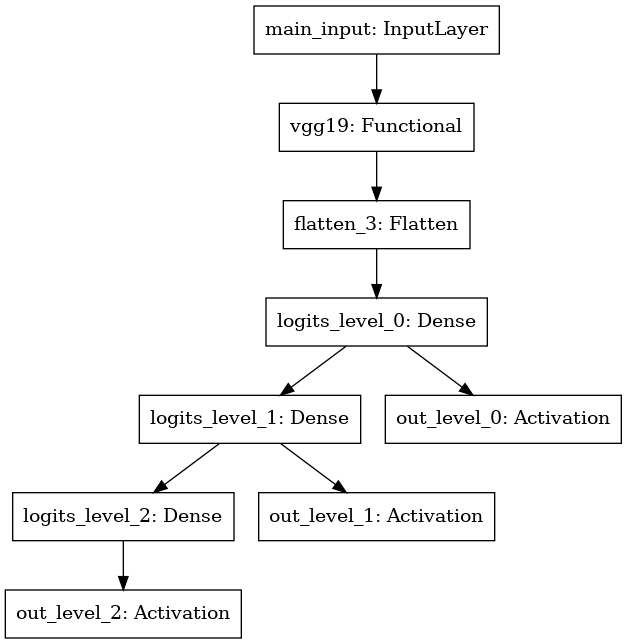

In [7]:
# Create the model
BCNN2_model = models.get_BCNN2(num_classes, dataset.image_size)
BCNN2_model.summary()
#train model
history_BCNN2_model = BCNN2_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback, model_checkpoint_callback]
                    )
plot_model(BCNN2_model)

Model: "Model_BCNN2_reversed_True"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
vgg19 (Functional)              (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 512)          0           vgg19[1][0]                      
__________________________________________________________________________________________________
logits_level_2 (Dense)          (None, 100)          51300       flatten_4[0][0]                  
__________________________________________________________________________

INFO:tensorflow:Assets written to: /tmp/checkpoint_new/assets
Epoch 8/50
391/391 [==============================] - 13s 33ms/step - loss: 0.8028 - out_level_0_loss: 0.0450 - out_level_1_loss: 0.7058 - out_level_2_loss: 1.6575 - out_level_0_accuracy: 0.9852 - out_level_1_accuracy: 0.7782 - out_level_2_accuracy: 0.5655 - val_loss: 1.4064 - val_out_level_0_loss: 0.3613 - val_out_level_1_loss: 1.4861 - val_out_level_2_loss: 2.3719 - val_out_level_0_accuracy: 0.9192 - val_out_level_1_accuracy: 0.6208 - val_out_level_2_accuracy: 0.4446
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.3894, accuracy level_0 = 0.9192, accuracy level_1 = 0.6208, accuracy level_2 = 0.4444, Consistency = 0.6960
----------------------------------------------------------------------------------------------------

Epoch 9/50
391/391 [==============================] - 13s 33ms/step - loss: 0.6905 - out_level_0_loss: 0.0341 - out_level_1_loss

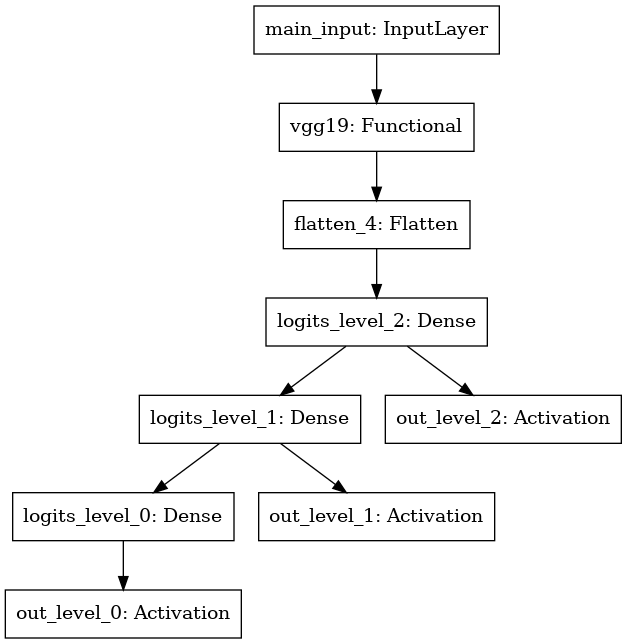

In [8]:
# Create the model
BCNN2_reversed_model = models.get_BCNN2(num_classes, dataset.image_size, reverse=True)
BCNN2_reversed_model.summary()
#train model
history_BCNN2_reversed_model = BCNN2_reversed_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback, model_checkpoint_callback]
                    )
plot_model(BCNN2_reversed_model)


Model: "mnets"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv_base0 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base1 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
__________________________________________________________________________________________________
conv_base2 (Functional)         (None, None, None, 5 20024384    main_input[0][0]                 
______________________________________________________________________________________________

INFO:tensorflow:Assets written to: /tmp/checkpoint_new/assets
Epoch 8/50
391/391 [==============================] - 34s 86ms/step - loss: 0.9813 - out_level_0_loss: 0.1075 - out_level_1_loss: 0.9638 - out_level_2_loss: 1.8726 - out_level_0_accuracy: 0.9591 - out_level_1_accuracy: 0.6908 - out_level_2_accuracy: 0.5155 - val_loss: 1.2402 - val_out_level_0_loss: 0.2387 - val_out_level_1_loss: 1.2434 - val_out_level_2_loss: 2.2384 - val_out_level_0_accuracy: 0.9128 - val_out_level_1_accuracy: 0.6184 - val_out_level_2_accuracy: 0.4370
----------------------------------------------------------------------------------------------------
epoch=8, Exact Match = 0.3654, accuracy level_0 = 0.9128, accuracy level_1 = 0.6184, accuracy level_2 = 0.4370, Consistency = 0.6016
----------------------------------------------------------------------------------------------------

INFO:tensorflow:Assets written to: /tmp/checkpoint_new/assets
Epoch 9/50
391/391 [==============================] - 34s 86ms/ste

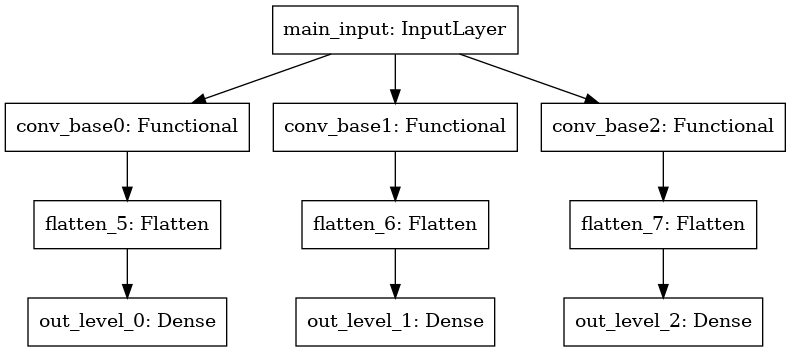

In [9]:
# Create the model
mnets_model = models.get_mnets(num_classes, dataset.image_size, reverse=True)
mnets_model.summary()
#train model
history_mnets_model = mnets_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback, model_checkpoint_callback]
                    )
plot_model(mnets_model)


Model: "baseline_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
flatten_121 (Flatten)        (None, 512)               0         
_________________________________________________________________
output (Dense)               (None, 100)               51300     
Total params: 20,075,684
Trainable params: 20,075,684
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
391/391 [==============================] - 13s 32ms/step - loss: 5.2429 - accuracy: 0.0209 - val_loss: 4.4688 - val_accuracy: 0.0398
----------------------------------------------------------------------------------------------

391/391 [==============================] - 13s 32ms/step - loss: 0.8826 - accuracy: 0.7558 - val_loss: 2.2178 - val_accuracy: 0.4982
----------------------------------------------------------------------------------------------------
epoch=16, Exact Match = 0.4982, accuracy level_0 = 0.9202, accuracy level_1 = 0.6432, accuracy level_2 = 0.4982, Consistency = 1.0000
----------------------------------------------------------------------------------------------------



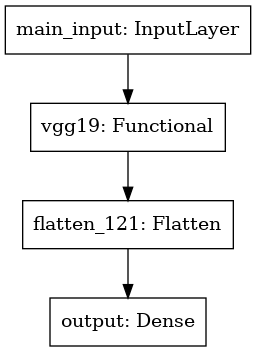

In [112]:
# Create the model
baseline_model = models.get_Baseline_model(num_classes, dataset.image_size, dataset.taxonomy)
baseline_model.summary()
#train model
history_baseline_model = baseline_model.fit(dataset.X_train, 
                    dataset.y_train[-1],
                    validation_data = (dataset.X_val, dataset.y_val[-1]),
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(baseline_model)


Model: "MLPH_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
model_33 (Functional)           [(None, None, None,  17664576    main_input[0][0]                 
__________________________________________________________________________________________________
flatten_117 (Flatten)           (None, 2048)         0           model_33[0][0]                   
__________________________________________________________________________________________________
flatten_118 (Flatten)           (None, 2048)         0           model_33[0][1]                   
_________________________________________________________________________________________

----------------------------------------------------------------------------------------------------
epoch=5, Exact Match = 0.0010, accuracy level_0 = 0.6198, accuracy level_1 = 0.0648, accuracy level_2 = 0.0114, Consistency = 0.0282
----------------------------------------------------------------------------------------------------

Epoch 6/50
391/391 [==============================] - 13s 33ms/step - loss: 6.7448 - out_level_0_loss: 1.8196 - out_level_1_loss: 7.4942 - out_level_2_loss: 10.9207 - out_level_0_accuracy: 0.6285 - out_level_1_accuracy: 0.0620 - out_level_2_accuracy: 0.0118 - val_loss: 5.4429 - val_out_level_0_loss: 1.3550 - val_out_level_1_loss: 6.2647 - val_out_level_2_loss: 8.7091 - val_out_level_0_accuracy: 0.6466 - val_out_level_1_accuracy: 0.0662 - val_out_level_2_accuracy: 0.0130
----------------------------------------------------------------------------------------------------
epoch=6, Exact Match = 0.0010, accuracy level_0 = 0.6466, accuracy level_1 = 0.0662, acc

391/391 [==============================] - 13s 33ms/step - loss: 2.6650 - out_level_0_loss: 0.5492 - out_level_1_loss: 2.8538 - out_level_2_loss: 4.5920 - out_level_0_accuracy: 0.7533 - out_level_1_accuracy: 0.1568 - out_level_2_accuracy: 0.0307 - val_loss: 2.6562 - val_out_level_0_loss: 0.5458 - val_out_level_1_loss: 2.8482 - val_out_level_2_loss: 4.5746 - val_out_level_0_accuracy: 0.7602 - val_out_level_1_accuracy: 0.1592 - val_out_level_2_accuracy: 0.0334
----------------------------------------------------------------------------------------------------
epoch=16, Exact Match = 0.0126, accuracy level_0 = 0.7602, accuracy level_1 = 0.1592, accuracy level_2 = 0.0334, Consistency = 0.1128
----------------------------------------------------------------------------------------------------

Epoch 17/50
391/391 [==============================] - 13s 33ms/step - loss: 2.6154 - out_level_0_loss: 0.5314 - out_level_1_loss: 2.7891 - out_level_2_loss: 4.5257 - out_level_0_accuracy: 0.7612 - ou

391/391 [==============================] - 13s 33ms/step - loss: 2.1620 - out_level_0_loss: 0.4289 - out_level_1_loss: 2.2652 - out_level_2_loss: 3.7918 - out_level_0_accuracy: 0.8184 - out_level_1_accuracy: 0.3022 - out_level_2_accuracy: 0.1286 - val_loss: 2.1718 - val_out_level_0_loss: 0.4404 - val_out_level_1_loss: 2.2748 - val_out_level_2_loss: 3.8001 - val_out_level_0_accuracy: 0.8164 - val_out_level_1_accuracy: 0.2998 - val_out_level_2_accuracy: 0.1320
----------------------------------------------------------------------------------------------------
epoch=26, Exact Match = 0.0804, accuracy level_0 = 0.8164, accuracy level_1 = 0.2998, accuracy level_2 = 0.1324, Consistency = 0.3348
----------------------------------------------------------------------------------------------------

Epoch 27/50
391/391 [==============================] - 13s 33ms/step - loss: 2.1230 - out_level_0_loss: 0.4195 - out_level_1_loss: 2.2255 - out_level_2_loss: 3.7239 - out_level_0_accuracy: 0.8222 - ou

391/391 [==============================] - 13s 33ms/step - loss: 1.7973 - out_level_0_loss: 0.3462 - out_level_1_loss: 1.8923 - out_level_2_loss: 3.1535 - out_level_0_accuracy: 0.8581 - out_level_1_accuracy: 0.4142 - out_level_2_accuracy: 0.2396 - val_loss: 1.8368 - val_out_level_0_loss: 0.3615 - val_out_level_1_loss: 1.9326 - val_out_level_2_loss: 3.2164 - val_out_level_0_accuracy: 0.8498 - val_out_level_1_accuracy: 0.4140 - val_out_level_2_accuracy: 0.2252
----------------------------------------------------------------------------------------------------
epoch=36, Exact Match = 0.1558, accuracy level_0 = 0.8498, accuracy level_1 = 0.4140, accuracy level_2 = 0.2252, Consistency = 0.4516
----------------------------------------------------------------------------------------------------

Epoch 37/50
391/391 [==============================] - 13s 33ms/step - loss: 1.7619 - out_level_0_loss: 0.3362 - out_level_1_loss: 1.8564 - out_level_2_loss: 3.0931 - out_level_0_accuracy: 0.8626 - ou

391/391 [==============================] - 13s 33ms/step - loss: 1.4628 - out_level_0_loss: 0.2705 - out_level_1_loss: 1.5438 - out_level_2_loss: 2.5740 - out_level_0_accuracy: 0.8923 - out_level_1_accuracy: 0.5155 - out_level_2_accuracy: 0.3470 - val_loss: 1.5464 - val_out_level_0_loss: 0.2960 - val_out_level_1_loss: 1.6376 - val_out_level_2_loss: 2.7055 - val_out_level_0_accuracy: 0.8882 - val_out_level_1_accuracy: 0.4970 - val_out_level_2_accuracy: 0.3276
----------------------------------------------------------------------------------------------------
epoch=46, Exact Match = 0.2466, accuracy level_0 = 0.8882, accuracy level_1 = 0.4970, accuracy level_2 = 0.3276, Consistency = 0.5576
----------------------------------------------------------------------------------------------------

Epoch 47/50
391/391 [==============================] - 13s 33ms/step - loss: 1.4288 - out_level_0_loss: 0.2639 - out_level_1_loss: 1.5049 - out_level_2_loss: 2.5176 - out_level_0_accuracy: 0.8943 - ou

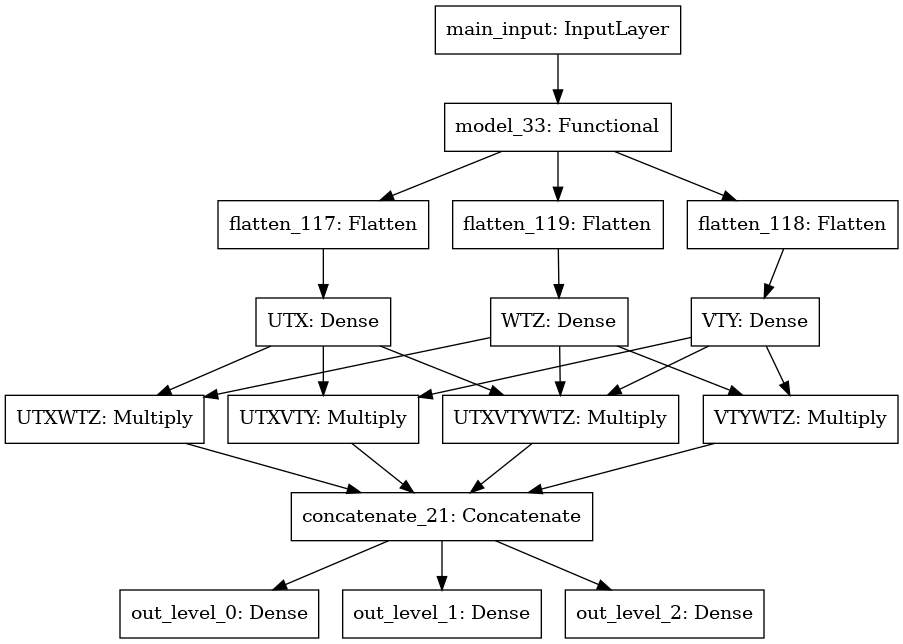

In [109]:
# Create the model
MLPH_model = models.get_MLPH_model(num_classes, dataset.image_size)
MLPH_model.summary()
#train model
history_MLPH_model = MLPH_model.fit(dataset.X_train, 
                    dataset.y_train,
                    validation_data = (dataset.X_val, dataset.y_val), 
                    batch_size=batch, 
                    epochs=epochs,
                    callbacks=[performance_callback, early_stopping_callback]
                    )
plot_model(MLPH_model,show_shapes=False, expand_nested=False, dpi=96)



In [113]:
mout_pred = mout_model.predict(dataset.X_test)
mout_pred = models.get_pred_indexes(mout_pred)

BCNN1_pred = BCNN1_model.predict(dataset.X_test)
BCNN1_pred = models.get_pred_indexes(BCNN1_pred)

BCNN1_reversed_pred = BCNN1_reversed_model.predict(dataset.X_test)
BCNN1_reversed_pred = models.get_pred_indexes(BCNN1_reversed_pred)

BCNN2_pred = BCNN2_model.predict(dataset.X_test)
BCNN2_pred = models.get_pred_indexes(BCNN2_pred)

BCNN2_reversed_pred = BCNN2_reversed_model.predict(dataset.X_test)
BCNN2_reversed_pred = models.get_pred_indexes(BCNN2_reversed_pred)

mnets_model_pred = mnets_model.predict(dataset.X_test)
mnets_model_pred = models.get_pred_indexes(mnets_model_pred)

baseline_model_pred = baseline_model.predict(dataset.X_test)
baseline_model_pred = models.get_pred_indexes(baseline_model_pred)

MLPH_pred = MLPH_model.predict(dataset.X_test)
MLPH_pred = models.get_pred_indexes(MLPH_pred)


In [114]:
exact_match_scores = [metrics.get_exact_match(mout_pred, dataset.y_test),
     metrics.get_exact_match(BCNN1_pred, dataset.y_test),
     metrics.get_exact_match(BCNN1_reversed_pred, dataset.y_test),
     metrics.get_exact_match(BCNN2_pred, dataset.y_test),
     metrics.get_exact_match(BCNN2_reversed_pred, dataset.y_test),
     metrics.get_exact_match(mnets_model_pred, dataset.y_test),
     metrics.get_exact_match(baseline_model_pred, dataset.y_test),
                      metrics.get_exact_match(MLPH_pred, dataset.y_test)]

h_accuracy_scores = [metrics.get_h_accuracy(mout_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN1_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN1_reversed_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN2_pred, dataset.y_test),
     metrics.get_h_accuracy(BCNN2_reversed_pred, dataset.y_test),
     metrics.get_h_accuracy(mnets_model_pred, dataset.y_test),
     metrics.get_h_accuracy(baseline_model_pred, dataset.y_test), 
    metrics.get_h_accuracy(MLPH_pred, dataset.y_test)]

m_accuracy_scores = [metrics.get_m_accuracy(mout_pred, dataset.y_test),
     metrics.get_m_accuracy(BCNN1_pred, dataset.y_test),
     metrics.get_m_accuracy(BCNN1_reversed_pred, dataset.y_test),
     metrics.get_m_accuracy(BCNN2_pred, dataset.y_test),
     metrics.get_m_accuracy(BCNN2_reversed_pred, dataset.y_test),
     metrics.get_m_accuracy(mnets_model_pred, dataset.y_test),
     metrics.get_m_accuracy(baseline_model_pred, dataset.y_test),
                    metrics.get_m_accuracy(MLPH_pred, dataset.y_test)]


consistency = [metrics.get_consistency(mout_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN1_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN1_reversed_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN2_pred, dataset.taxonomy),
     metrics.get_consistency(BCNN2_reversed_pred, dataset.taxonomy),
     metrics.get_consistency(mnets_model_pred, dataset.taxonomy),
     metrics.get_consistency(baseline_model_pred, dataset.taxonomy),
              metrics.get_consistency(MLPH_pred, dataset.taxonomy)]

# Create example dataframe
df = pd.DataFrame({
'exact_match': exact_match_scores,
'h_accuracy': h_accuracy_scores,
'm_accuracy': m_accuracy_scores,
'consistency': consistency,
's': [3000,3000,3000,3000,3000,3000,3000,3000],
'algo': ['mout','BCNN1','BCNN1_R','BCNN2','BCNN2_R', 'mnets', 'baseline', 'MLPH']
})


/home/reda/PycharmProjects/Masked-CNN/python3.8_mcnn/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


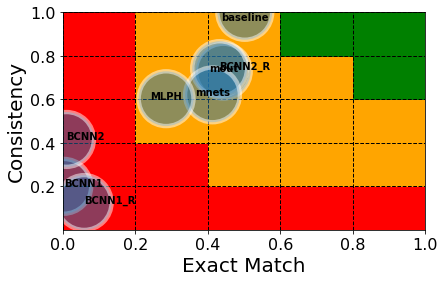

In [115]:
plt.figure(figsize=(6.5, 4))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16,
          'axes.titlepad': 25,
          'font.size': 10}
plt.rcParams.update(params)

ax = sns.scatterplot(df.exact_match, df.consistency, alpha = 0.5,s = df.s)

ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
plt.yticks([0.2,0.4,0.6,0.8,1.0])
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])

ax.set_xlim(0,1)
ax.set_ylim(0, 1)
plt.xlabel('Exact Match')
plt.ylabel('Consistency')
#For each point, we add a text inside the bubble
for line in range(0,df.shape[0]):
    if df.algo[line]=='baseline':
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], verticalalignment='top', horizontalalignment='center', size='medium', color='black', weight='semibold')
    elif df.algo[line].startswith('BCNN'):
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='left', size='medium', color='black', weight='semibold')
    else:
        ax.text(df.exact_match[line], df.consistency[line], df.algo[line], horizontalalignment='center', size='medium', color='black', weight='semibold')



currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((0., 0.), 1., 0.2, color = 'red', zorder=0))
currentAxis.add_patch(Rectangle((0., 0.), .2, 1., color = 'red',zorder=0))
currentAxis.add_patch(Rectangle((0.2, 0.2), 0.2, 0.2, color = 'red', zorder=0))

currentAxis.add_patch(Rectangle((0.2, 0.4), 0.4, 1.0, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.4, 0.2), 1., 0.4, color = 'orange', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.6), 0.2, 0.2, color = 'orange', zorder=0))

currentAxis.add_patch(Rectangle((0.8, 0.6), 0.2, 0.4, color = 'green', zorder=0))
currentAxis.add_patch(Rectangle((0.6, 0.8), 0.4, 0.2, color = 'green', zorder=0))
# plotlim = plt.xlim() + plt.ylim()
# import matplotlib.colors

# cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])

# ax.imshow([[0.5, 0.5, 0.5], [0, 0.5, 0.5], [0, 0, 0.5]],
#           cmap=cmap,
#           interpolation='bicubic',
#           extent=plotlim, vmin=0, vmax=0.5)
        
plt.savefig('plots/bubble_plot.pdf', bbox_inches = 'tight')
plt.show()


In [ ]:
class Custom_Layer(keras.layers.Layer):
    def __init__(self, M, mode='both'):
        super(Custom_Layer, self).__init__()
        self.M = M
        if mode in ['both', 'c_to_f', 'f_to_c']:
          self.mode = mode

    def build(self, input_shape):
        """Creates scale variable if use_scale==True."""
        if isinstance(input_shape, list):
          input_dim1 = input_shape[0][1]
          input_dim2 = input_shape[0][1]
        else:
          input_dim1 = input_shape[1]
          input_dim2 = input_shape[1]
        
        units_c = len(self.M)
        units_f = len(self.M[0])
        self.M = tf.convert_to_tensor(self.M, dtype=tf.float32)

        self.W_c = self.add_weight(
            shape=(input_dim1, units_c), initializer="random_normal", trainable=True
        )
        self.b_c = self.add_weight(shape=(units_c,), initializer="zeros", trainable=True)
        self.W_f = self.add_weight(
            shape=(input_dim2, units_f), initializer="random_normal", trainable=True
        )
        self.b_f = self.add_weight(shape=(units_f,), initializer="zeros", trainable=True)

    def call(self, inputs):
      # Code the six equation
      if isinstance(inputs, list):
        inputs1 = inputs[0]
        inputs2 = inputs[1]
      else:
        inputs1 = inputs
        inputs2 = inputs
      
      z_c = tf.matmul(inputs1, self.W_c) + self.b_c # z^{(i)}_{c}= a^{[l]} \times W_{c} + b_{c}
      z_f = tf.matmul(inputs2, self.W_f) + self.b_f #  z^{(i)}_{f}= a^{[l]} \times  W_{f}+ b_{f}
      if self.mode == 'both' or self.mode == 'f_to_c':
        m_c = tf.matmul(tf.nn.softmax(z_f), tf.transpose(self.M)) # m^{(i)}_{c}= softmax(z^{(i)}_{f})\times M^{T}            
        y_c = tf.nn.softmax(z_c * m_c) # \hat{y}^{(i)}_{c}= softmax(z^{(i)}_{c}\circ m^{(i)}_{c})
      else:
        y_c = tf.nn.softmax(z_c)

      if self.mode == 'both' or self.mode == 'c_to_f':
        m_f = tf.matmul(tf.nn.softmax(z_c), self.M) #  m^{(i)}_{f}= softmax(z^{(i)}_{c})\times M
        y_f = tf.nn.softmax(z_f * m_f) # \hat{y}^{(i)}_{f}= softmax(z^{(i)}_{f}\circ m^{(i)}_{f})
      else:
        y_f = tf.nn.softmax(z_f)

      return y_c, y_f

    def get_config(self):
        config = {'M': self.M, 
                  'W_c': self.W_c,
                  'W_f': self.W_f,
                  'b_f': self.b_f,
                  'b_f': self.b_f}
        base_config = super(Custom_Layer, self).get_config()
        return base_config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [ ]:
def get_model7(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    in_layer = Input(shape=dataset.image_size, name='main_input')
    conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")(in_layer)
    conv_base = Flatten()(conv_base)
    # outputs 
    out_c, out_f = Custom_Layer(M, mode)(conv_base)
    # Build the model
    model = Model(name='Model_7',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

model = get_model7()
model.summary()
plot_model(model)


In [ ]:
def get_model8(learning_rate=1e-5, pi=0.5, mode='both'):
    # Conv base
    conv_base1 = keras.applications.VGG19(
    include_top=False,
    weights="imagenet")
    conv_base1._name = 'vgg19_1'
    conv_base2 = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
    conv_base2._name = 'vgg19_2'
    in_layer = Input(shape=image_size, name='main_input')
    conv_base1 = conv_base1(in_layer)    
    conv_base1 = Flatten()(conv_base1)

    conv_base2 = conv_base2(in_layer)
    conv_base2 = Flatten()(conv_base2)

    out_c, out_f = Custom_Layer(M, mode)([conv_base1, conv_base2])
    # Build the model
    model = Model(name='Model_8',
            inputs=in_layer,
            outputs=[out_c, out_f])
    loss = keras.losses.SparseCategoricalCrossentropy()
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, 
                  loss=[loss, loss],
                  loss_weights=[1-pi, pi],
                  metrics=['accuracy'])
    return model

# model = get_model8()
# model.summary()
# plot_model(model)

In [ ]:
data = pd.DataFrame(columns=['algo','accuracy'])
data_list = list(zip(['Coarse-grained\n classifier']*len(accuracy_c), accuracy_c))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

data_list = list(zip(['Fine-grained\n classifier']*len(accuracy_f), accuracy_f))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy']),ignore_index=True)

plt.figure(figsize=(5.5, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% correct predictions")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency'])

data_list = list(zip(['XXX']*len(consistency), consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")

plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency2'])

data_list = list(zip(['XXX']*len(consistency2), consistency2))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency2']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency2", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','consistency3'])

data_list = list(zip(['XXX']*len(consistency3), consistency3))
data = data.append(pd.DataFrame(data_list, columns=['algo','consistency3']),ignore_index=True)

plt.figure(figsize=(2, 3.8))
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
ax = sns.barplot(x="algo", y="consistency3", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("% inconsistent preds")
# plt.title("Box plot of #candidates per cycle and system")
plt.ylim(0, 100)
plt.xticks(rotation=0)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
data = pd.DataFrame(columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency'])

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi1, X_test, y_test)
# data_list = list(zip(['model1_pi1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0, X_test, y_test)
# data_list = list(zip(['model1_pi0']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model1_pi0_5, X_test, y_test)
data_list = list(zip(['model1_pi0.5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model2, X_test, y_test)
# data_list = list(zip(['model2']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model3, X_test, y_test)
# data_list = list(zip(['model3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

# accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model4, X_test, y_test)
# data_list = list(zip(['model4']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
# data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model5, X_test, y_test)
data_list = list(zip(['model5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model6, X_test, y_test)
data_list = list(zip(['model6']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_c_to_f_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_c_to_f_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_1, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_1']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_3, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_3']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_5, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_5']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_7, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_7']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model7_f_to_c_pi_0_9, X_test, y_test)
data_list = list(zip(['model7_f_to_c_pi_0_9']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)





accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8, X_test, y_test)
data_list = list(zip(['model8']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_c_to_f, X_test, y_test)
data_list = list(zip(['model8_c_to_f']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)

accuracy, accuracy_c, accuracy_f, accuracy_c_no_f, accuracy_f_no_c, accuracy_no_f_no_c, accuracy_consistency, consistency = get_metrics(model8_f_to_c, X_test, y_test)
data_list = list(zip(['model8_f_to_c']*len(accuracy), accuracy, accuracy_c, accuracy_f, accuracy_consistency, consistency))
data = data.append(pd.DataFrame(data_list, columns=['algo','accuracy','accuracy_c', 'accuracy_f', 'accuracy_consistency', 'consistency']),ignore_index=True)


In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.3, 0.52)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_c", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_c")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_f", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("Accuracy_f")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.4, 0.55)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="accuracy_consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("accuracy_consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.65, 0.85)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()

In [ ]:
# statistic, pvalue = stats.ttest_ind(acc2, acc_baseline2)
plt.figure(figsize=(20, 3.8))

ax = sns.barplot(x="algo", y="consistency", data=data, ci=95, capsize=.2)
# ax.text(.5,.87,f"p-value = {pvalue:.4f} ≮ 0.05",
#         horizontalalignment='center',
#         transform=ax.transAxes,
#        bbox=dict(facecolor='white', edgecolor='none'))
ax.grid(color='black', linestyle='--', linewidth=1)
ax.set_axisbelow(True)

plt.xlabel("")
plt.ylabel("consistency")
# plt.title("Box plot of #candidates per cycle and system")
params = {'legend.fontsize': 18,
          'axes.labelsize': 20,
          'axes.titlesize': 14,
          'xtick.labelsize': 20,
          'ytick.labelsize': 18,
          'axes.titlepad': 25,
          'font.size': 24}
plt.rcParams.update(params)
plt.ylim(0.7, 1.)
plt.xticks(rotation=90)
# plt.savefig('plots/em_SQuAD2.0.eps', bbox_inches = 'tight')
plt.show()


In [ ]:
plt.figure(figsize=(15,4))
ax1 = plt.subplot(1, 2, 1)
for l in history_MLPH_model.history:
    if l == 'loss' or l == 'val_loss':  
        loss = history_MLPH_model.history[l]
        plt.plot(range(1, len(loss) + 1), loss, label=l)
        
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

ax2 = plt.subplot(1, 2, 2)
for k in history_MLPH_model.history:
    if 'accuracy' in k:  
        loss = history_MLPH_model.history[k]
        plt.plot(range(1, len(loss) + 1), loss, label=k)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def nin(input_shape):
    # Define Network in Network model
    input = Input(shape=input_shape)
    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(input)
    x = Conv2D(filters=160, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=96, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(5,5), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = MaxPool2D(2, strides=2, padding='same')(x)
    x = Dropout(0.5)(x)

    x = Conv2D(filters=192, kernel_size=(3,3), activation='relu')(x)
    x = Conv2D(filters=192, kernel_size=(1,1), activation='relu')(x)
    x = Conv2D(filters=10, kernel_size=(1,1), activation='relu')(x)

    output = GlobalAveragePooling2D()(x)

    model = Model(input, output)

    return model 


    
model = nin(input_shape=(28,28,1))

model.summary()


In [ ]:
conv_base = keras.applications.VGG19(
        include_top=False,
        weights="imagenet")
type(model)